In [822]:
%matplotlib inline
from collections import defaultdict
import cPickle
import gzip
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from ete3 import NCBITaxa

## Plot function: blast vs eggNOG

In [863]:
def plot_blast_benchmark(benchmark, target_taxa, target_cutoffs, ylabel, emapper_tag):
    f, axes = plt.subplots(5, 3, figsize=(15, 15))
    for i, taxa in enumerate(target_taxa):
        if taxa not in benchmark: 
            continue       
        data = benchmark[taxa]
        first_row = data.loc[target_cutoffs[0]]
        
        ylim = (-2, (len(target_cutoffs))*len(target_taxa) )
        ytick_labels = reversed(target_cutoffs)
        yticks = range(0, len(target_cutoffs)*len(target_taxa), 5)
        
        # PLOT FIRST COLUMN
        # =========================
        drate = axes[i][0]      
        drate.set_axis_bgcolor('white')
        #drate.get_yaxis().set_visible(False)
        drate.spines['right'].set_visible(False)
        drate.spines['top'].set_visible(False)
        drate.spines['left'].set_visible(False)
        drate.get_xaxis().tick_bottom()
        drate.get_yaxis().tick_left()
        drate.set_xlabel("% TP and FP GO terms per protein", {'fontsize': 13})    
        drate.set_yticks(yticks)        
        drate.set_yticklabels(ytick_labels)
        drate.set_xlim((0, 100))
        drate.set_ylim(ylim)    
        #drate.yaxis.tick_right()

        rn = 0
        for name, row in reversed([r for r in data.iterrows()]):        
            htp_prop = row.htp_ratio * 100
            hfp_prop = 100 - htp_prop

            otp_prop = row.otp_ratio * 100
            ofp_prop = 100 - otp_prop 


            a = drate.barh((rn-2), htp_prop, height=1.9, color='darkgreen',linewidth=0, alpha=0.4, 
                           label="True Positives (Blast)")
            b = drate.barh((rn-2), hfp_prop, height=1.9, left=htp_prop, 
                           color='indianred',linewidth=0, alpha=0.4, 
                           label="False Positives (Blast)")        

            c = drate.barh((rn+0.1), otp_prop, height=1.9, color='darkgreen', linewidth=0, alpha=0.9, 
                           label="True Positives (eggNOG)")
            d = drate.barh((rn+0.1), ofp_prop, height=1.9, left=otp_prop, 
                           color='indianred',linewidth=0, alpha=0.9, 
                           label="False Positives (eggNOG)")                    

            rn += 5.0

        # PLOT SECOND COLUMN
        # =========================

        cov = axes[i][1]
        cov.spines['right'].set_visible(False)
        cov.spines['top'].set_visible(False)
        cov.spines['left'].set_visible(False)
        cov.get_xaxis().tick_bottom()

        cov.set_xlabel("Average GO terms per protein", {'fontsize': 13})
        cov.set_yticks([])
        cov.set_ylim(ylim)    

        rn = 0    
        max_gos = first_row.htp + first_row.hfp + first_row.hunk
        cov.set_xlim(0, max_gos)
        for name, row in reversed([r for r in data.iterrows()]):                            
            La = cov.barh((rn+0.1), row.otp, 
                         height=1.9, color='darkgreen',linewidth=0, alpha=0.9, 
                         label='True Positive terms (eggNOG)')
            Lb = cov.barh((rn+0.1), row.ofp, left=row.otp, 
                         height=1.9, color='indianred',linewidth=0, alpha=0.9,
                         label='False Positive terms (eggNOG)')
            Lc = cov.barh((rn+0.1), row.ounk, left=(row.otp+row.ofp),
                         height=1.9, color='darkgrey',linewidth=0, alpha=0.9,
                         label='Not curated terms (eggNOG)')

            Ld = cov.barh((rn-2), row.htp, 
                         height=1.9, color='darkgreen',linewidth=0, alpha=0.4, label='(BLAST)')
            Le = cov.barh((rn-2), row.hfp, left=row.htp, 
                         height=1.9, color='indianred',linewidth=0, alpha=0.4, label='(BLAST)')
            Lf = cov.barh((rn-2), row.hunk, left=(row.htp+row.hfp),
                         height=1.9, color='darkgrey',linewidth=0, alpha=0.4, label='(BLAST)')


            hratio = row.htp / (row.htp + row.hfp + row.hunk)
            oratio = row.otp / (row.otp + row.ofp + row.ounk)
            cov.text(max_gos, rn+0.4, '%0.2f ' %oratio, horizontalalignment='right', color = "blue")
            cov.text(max_gos, rn-1.4, '%0.2f ' %hratio, horizontalalignment='right')
            rn += 5.0

            if taxa == '9606' and name == target_cutoffs[0]:
                cov.text(max_gos, rn-2.5, 'TP ratio\n(higher is better)', 
                         horizontalalignment='right', fontweight="bold", fontsize=8)


        # PLOT THIRD COLUMN
        # =========================
        cov = axes[i][2]
        cov.spines['right'].set_visible(False)
        cov.spines['top'].set_visible(False)
        cov.spines['left'].set_visible(False)
        cov.get_xaxis().tick_bottom()
        cov.set_xlabel("% of proteome annotated", {'fontsize': 13})
        cov.set_yticks([])        
        cov.set_ylim(ylim)    
        #cov.get_xaxis().tick_right()

        rn = 0    
        psize = PROTEOME_SIZE[taxa]/100
        cov.set_xlim(0, 100)
        for name, row in reversed([r for r in data.iterrows()]):                            
            Lg = cov.barh((rn+0.1), row.op_tponly/psize, 
                         height=1.9, color='darkblue',linewidth=0, alpha=0.9, 
                         label='Proteins with only TP terms (eggNOG)')
            
            Lh = cov.barh((rn+0.1), row.op_tpplus/psize, left=row.op_tponly/psize, 
                         height=1.9, color='purple',linewidth=0, alpha=0.9,
                         label='Proteins with TP and other terms (eggNOG)')
            
            Li = cov.barh((rn+0.1), row.op_notp/psize, left=(row.op_tponly + row.op_tpplus)/psize,
                         height=1.9, color='orange',linewidth=0, alpha=0.9,
                         label='Proteins lacking TP terms (eggNOG)')

            Lj = cov.barh((rn-2), row.hp_tponly/psize, 
                         height=1.9, color='darkblue',linewidth=0, alpha=0.4, label='(BLAST)')
            Lk = cov.barh((rn-2), row.hp_tpplus/psize, left=row.hp_tponly/psize, 
                         height=1.9, color='purple',linewidth=0, alpha=0.4, label='(BLAST)')
            Lm = cov.barh((rn-2), row.hp_notp/psize, left=(row.hp_tponly + row.hp_tpplus)/psize,
                         height=1.9, color='orange',linewidth=0, alpha=0.4, label='(BLAST)')

            hratio = row.hp_notp / (row.hp_notp + row.hp_tponly + row.hp_tpplus)
            oratio = row.op_notp / (row.op_notp + row.op_tponly + row.op_tpplus)

            cov.text(100, rn+0.4, '%0.2f ' %oratio, horizontalalignment='right', color = "blue")
            cov.text(100, rn-1.4, '%0.2f ' %hratio, horizontalalignment='right')

            rn += 5.0        
            if taxa == '9606' and name == target_cutoffs[0]:
                cov.text(100, rn-2.5, 'no-TP ratio\n(lower is better)', 
                         horizontalalignment='right', fontweight="bold", fontsize=8)


        if i == 0: 
            drate.legend(handles=[La, Lb, Lc, Ld, Le, Lf], loc=2, ncol=2, bbox_to_anchor=(0.1, 1.4))
            cov.legend(handles=[Lg, Lh, Li, Lj, Lk, Lm], loc=2, ncol=2, bbox_to_anchor=(-0.9, 1.4))
        #cov.yaxis.tick_right()
        cov.yaxis.set_label_position("right")
        drate.set_ylabel(ylabel, x=2, fontsize=13)
        cov.set_ylabel(taxa_names[int(taxa)], labelpad=30, fontsize=18, rotation=-90, style='italic')
        cov.get_yaxis().tick_right()
        # cov.margins(left=50)


    plt.subplots_adjust(left=None, bottom=0, right=None, top=1.02, wspace=None, hspace=None)    

    plt.savefig("emapper_vs_blast_benchmark.%s.pdf" %(emapper_tag), dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', bbox_inches = 'tight')

    plt.savefig("emapper_vs_blast_benchmark.%s.png" %(emapper_tag), dpi=150, facecolor='w', edgecolor='w',
            orientation='portrait', bbox_inches = 'tight')
    plt.show()

## Plot function: interproscan vs eggNOG

In [864]:
def plot_interpro_benchmark(benchmark, target_taxa, emapper_tag):
    f, axes = plt.subplots(1, 3, figsize=(18, 5))
    max_gos = max([(benchmark[t].mtp + benchmark[t].mfp + benchmark[t].munk)[0] for t in target_taxa])
    
    rn = 0
    labels = []
    for taxa in reversed(target_taxa):
        labels.append(' '.join(taxa_names.get(int(taxa), taxa).split()[:2]))

        if taxa not in benchmark: 
            rn += 5
            continue       

        row = benchmark[taxa].loc["0.001"]
        # PLOT FIRST COLUMN
        # =========================
        drate = axes[0]      
        yticks = range(2, len(target_taxa)*5, 5)
        ylim = (0, len(target_taxa)*5)
        if taxa == "9606":
            #drate.get_yaxis().set_visible(False)
            drate.spines['right'].set_visible(False)
            drate.spines['top'].set_visible(False)
            drate.spines['left'].set_visible(False)
            drate.get_xaxis().tick_bottom()
            drate.get_yaxis().tick_left()
            drate.set_xlabel("% TP and FP GO terms per protein", {'fontsize': 13})    
            drate.set_yticks(yticks) #[2, 7, 12, 17, 22])
            drate.set_yticklabels(labels, fontsize=15, style='italic')
            drate.set_xlim((0, 100))
            drate.set_ylim(ylim)    
            #drate.yaxis.tick_right()



        itp_prop = row.itp_ratio * 100
        ifp_prop = 100 - itp_prop

        otp_prop = row.mtp_ratio * 100
        ofp_prop = 100 - otp_prop 


        c = drate.barh((rn+2), otp_prop, height=1.9, color='darkgreen', linewidth=0, alpha=0.9, 
                       label="True Positives (eggNOG)")
        d = drate.barh((rn+2), ofp_prop, height=1.9, left=otp_prop, 
                       color='indianred',linewidth=0, alpha=0.9, 
                       label="False Positives (eggNOG)")                    

        a = drate.barh((rn-0.1), itp_prop, height=1.9, color='darkgreen',linewidth=0, alpha=0.4, 
                       label="True Positives (Blast)")
        b = drate.barh((rn-0.1), ifp_prop, height=1.9, left=itp_prop, 
                       color='indianred',linewidth=0, alpha=0.4, 
                       label="False Positives (Blast)")        


        # ROW IN SECOND COLUMN
        # =========================

        cov = axes[1]
        cov.set_xlabel("Average GO terms per protein", {'fontsize': 13})
        cov.spines['right'].set_visible(False)
        cov.spines['top'].set_visible(False)
        cov.spines['left'].set_visible(False)
        cov.get_xaxis().tick_bottom()        
        cov.set_yticks([])
        cov.set_ylim(ylim)    

        cov.set_xlim(0, max_gos)
        La = cov.barh((rn+2), row.mtp, 
                     height=1.9, color='darkgreen',linewidth=0, alpha=0.9, label='True Positives (TP) (eggNOG)')
        Lb = cov.barh((rn+2), row.mfp, left=row.mtp, 
                     height=1.9, color='indianred',linewidth=0, alpha=0.9, label='False Positives (FP) (eggNOG)')
        Lc = cov.barh((rn+2), row.munk, left=(row.mtp+row.mfp),
                     height=1.9, color='darkgrey',linewidth=0, alpha=0.9, label='Not curated terms (eggNOG)')

        Ld = cov.barh((rn-0.1), row.itp, 
                     height=1.9, color='darkgreen',linewidth=0, alpha=0.4, label='(interProScan)')
        Le = cov.barh((rn-0.1), row.ifp, left=row.itp, 
                     height=1.9, color='indianred',linewidth=0, alpha=0.4, label='(interProScan)')
        Lf = cov.barh((rn-0.1), row.iunk, left=(row.itp+row.ifp),
                     height=1.9, color='darkgrey',linewidth=0, alpha=0.4, label='(interProScan)')


        iratio = row.itp / (row.itp + row.ifp + row.iunk)
        oratio = row.mtp / (row.mtp + row.mfp + row.munk)
        cov.text(max_gos, rn+2.8, '%0.2f ' %oratio, horizontalalignment='right', color = "blue")
        cov.text(max_gos, rn+0.6, '%0.2f ' %iratio, horizontalalignment='right')

        if taxa == "9606":
            cov.text(max_gos, rn+4.5, 'TP ratio\n(higher is better)', 
                     horizontalalignment='right', fontweight="bold", fontsize=8)


        # ROW THIRD COLUMN
        # =========================
        cov = axes[2]
        cov.spines['right'].set_visible(False)
        cov.spines['top'].set_visible(False)
        cov.spines['left'].set_visible(False)
        cov.get_xaxis().tick_bottom()
        cov.set_yticks([])
        cov.set_ylim(ylim)    

        cov.set_xlabel("% of proteome annotated", {'fontsize': 13})

        psize = PROTEOME_SIZE[taxa]/100
        cov.set_xlim(0, 100)

        cov.barh((rn-0.1), 100, left=0, height=4, color='grey',linewidth=0, alpha=0.05)

        Lg = cov.barh((rn+2), row.mp_tponly/psize, 
                     height=1.9, color='darkblue',linewidth=0, alpha=0.9, 
                     label='Proteins with TP terms only (eggNOG)')
        
        Lh = cov.barh((rn+2), row.mp_tpplus/psize, left=row.mp_tponly/psize, 
                     height=1.9, color='purple',linewidth=0, alpha=0.9, 
                     label='Proteins with TP and other terms (eggNOG)')
        
        Li = cov.barh((rn+2), row.mp_notp/psize, left=(row.mp_tponly + row.mp_tpplus)/psize,
                     height=1.9, color='orange',linewidth=0, alpha=0.9, 
                    label='Proteins lacking TP terms (eggNOG)')

        Lj = cov.barh((rn-0.1), row.ip_tponly/psize, 
                     height=1.9, color='darkblue',linewidth=0, alpha=0.4, label='(interProScan)')
        
        Lk = cov.barh((rn-0.1), row.ip_tpplus/psize, left=row.ip_tponly/psize, 
                     height=1.9, color='purple',linewidth=0, alpha=0.4, label='(interProScan)')
        
        Lm = cov.barh((rn-0.1), row.ip_notp/psize, left=(row.ip_tponly + row.ip_tpplus)/psize,
                     height=1.9, color='orange',linewidth=0, alpha=0.4, label='(interProScan)')


        iratio = row.ip_notp / (row.ip_tponly + row.ip_tpplus + row.ip_notp)
        mratio = row.mp_notp / (row.mp_tponly + row.mp_tpplus + row.mp_notp)
        cov.text(100, rn+2.8, '%0.2f ' %mratio, horizontalalignment='right', color = "blue")
        cov.text(100, rn+0.6, '%0.2f ' %iratio, horizontalalignment='right')

        if taxa == "9606":
            cov.text(100, rn+4.5, 'no-TP ratio\n(lower is better)', 
                     horizontalalignment='right', fontweight="bold", fontsize=8)
        rn += 5.0       

        if taxa == "9606": 
            drate.legend(handles=[La, Lb, Lc, Ld, Le, Lf], loc=2, ncol=2, bbox_to_anchor=(0.1, 1.19))
            cov.legend(handles=[Lg, Lh, Li, Lj, Lk, Lm], loc=2, ncol=2, bbox_to_anchor=(-0.9, 1.19))

    plt.subplots_adjust(left=None, bottom=0, right=None, top=1.02, wspace=None, hspace=None)    

    plt.savefig("emapper_vs_interpro.%s.pdf" %emapper_tag, dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', bbox_inches = 'tight')

    plt.savefig("emapper_vs_interpro.%s.png" %emapper_tag, dpi=150, facecolor='w', edgecolor='w',
            orientation='portrait', bbox_inches = 'tight')
    plt.show()

0.001    43.293224
1e-10    43.293224
1e-40    43.293224
dtype: float64

In [760]:
def summary_table(A, B, benchmark, cutoff):
    tpfp_ratio_diff = []    
    tp_ratio_diff = []
    terms_per_prot_diff = []
    cov_diff = []
    notp_prots_diff = []
    tponly_prots_diff = []
    
    for taxa in reversed(TARGET_TAXA):
        row = benchmark[taxa].loc[cutoff]
        
        tpfp_ratio_diff.append((row["%stp_ratio" %A] - row["%stp_ratio" %B])*100)
        
        tp_ratio_A = row["%stp"%A] / (row["%stp"%A] + row["%sfp"%A] + row["%sunk"%A])
        tp_ratio_B = row["%stp"%B] / (row["%stp"%B] + row["%sfp"%B] + row["%sunk"%B])        
        tp_ratio_diff.append((tp_ratio_A - tp_ratio_B)*100)
        
        terms_A = (row["%stp"%A] + row["%sfp"%A] + row["%sunk"%A])
        terms_B = (row["%stp"%B] + row["%sfp"%B] + row["%sunk"%B]) 
        
        if terms_B > terms_A:
            terms_per_prot_diff.append((-terms_A / terms_B)*100)
        else:
            terms_per_prot_diff.append((terms_B / terms_A)*100)
        
        psize = PROTEOME_SIZE[taxa]/100
        cov_A = (row["%sp_tponly"%A] + row["%sp_tpplus"%A] + row["%sp_notp"%A]) /psize
        cov_B = (row["%sp_tponly"%B] + row["%sp_tpplus"%B] + row["%sp_notp"%B]) /psize
        cov_diff.append(cov_A - cov_B)
      
        notp_prots_A = row["%sp_notp"%A] / (row["%sp_tponly"%A] + row["%sp_tpplus"%A] + row["%sp_notp"%A])
        notp_prots_B = row["%sp_notp"%B] / (row["%sp_tponly"%B] + row["%sp_tpplus"%B] + row["%sp_notp"%B])                
        notp_prots_diff.append((notp_prots_A-notp_prots_B)*100)

        tponly_prots_A = row["%sp_tponly"%A] / (row["%sp_tponly"%A] + row["%sp_tpplus"%A] + row["%sp_notp"%A])
        tponly_prots_B = row["%sp_tponly"%B] / (row["%sp_tponly"%B] + row["%sp_tpplus"%B] + row["%sp_notp"%B])                
        tponly_prots_diff.append((tponly_prots_A - tponly_prots_B)*100)
        
    matrix = [tpfp_ratio_diff, tp_ratio_diff, terms_per_prot_diff, cov_diff, notp_prots_diff, tponly_prots_diff]
    for m in matrix: 
        mean = np.mean(m)
        median = np.median(m)
        std = np.std(m)
        m.insert(0, mean)
        m.insert(1, median)
        m.insert(2, std)
        
    
    return pd.DataFrame(matrix,  
                       index= map(str.strip, """TP/FP_per_protein_ratio_diff, TP_ratio_per_protein_diff,
                                                total_terms_per_prot_diff, 
                                                proteome_coverage_diff, notp_proteins_diff, 
                                                tponly_proteins_diff""".split(',')), 
                        columns=['AVERAGE', 'MEDIAN', "STD"]+[taxa_names[int(t)].split()[1] for t in TARGET_TAXA])

def print_summary_table(benchmark):
    cutoff = '1e-40'
    print '\neggNOG vs BLAST (% diff)\n==============================='
    blast = summary_table("o", "h", benchmark, cutoff)
    print blast.AVERAGE
    print '\neggNOG vs interpro (% diff)\n============================'
    interpro = summary_table("m", "i", benchmark, cutoff)
    print interpro.AVERAGE
    
    
    print '------------------------------------------------------------'
    print '\neggNOG vs BLAST (% diff)\n==============================='
    print blast
    print '\neggNOG vs interpro (% diff)\n============================'
    print interpro

# MAIN ANALYSIS

## SET TARGET PARAMETERS 

In [866]:
ncbi = NCBITaxa()
PROTEOME_SIZE = {'9606': 22834, '511145': 4146, '7227': 13937, '3702': 28128, '4932':6692, '5833':5429}
taxa_names = {k:' '.join(v.split()[:2]) for k,v in ncbi.get_taxid_translator(TARGET_TAXA).items()}
RESULTS_DIR = './'
TARGET_TAXA = ['9606', '7227', '3702', '4932', '511145']
EVALUE_CUTOFFS = ["0.001", "1e-10", "1e-40"]


In [839]:
bench = cPickle.load(open('all_benchmark_tables.pkl'))
print 'Available emapper tags:\n  ', '\n   '.join(sorted(bench.keys()))

Available emapper tags:
   all.NOG
   all.auto
   dmnd.all.NOG
   dmnd.all.auto
   dmnd.excluded_self.all.NOG
   dmnd.excluded_self.all.auto
   dmnd.excluded_self.one2one.NOG
   dmnd.excluded_self.one2one.auto
   dmnd.one2one.NOG
   dmnd.one2one.auto
   excluded_self.all.NOG
   excluded_self.all.auto
   excluded_self.one2one.NOG
   excluded_self.one2one.auto
   one2one.NOG
   one2one.auto


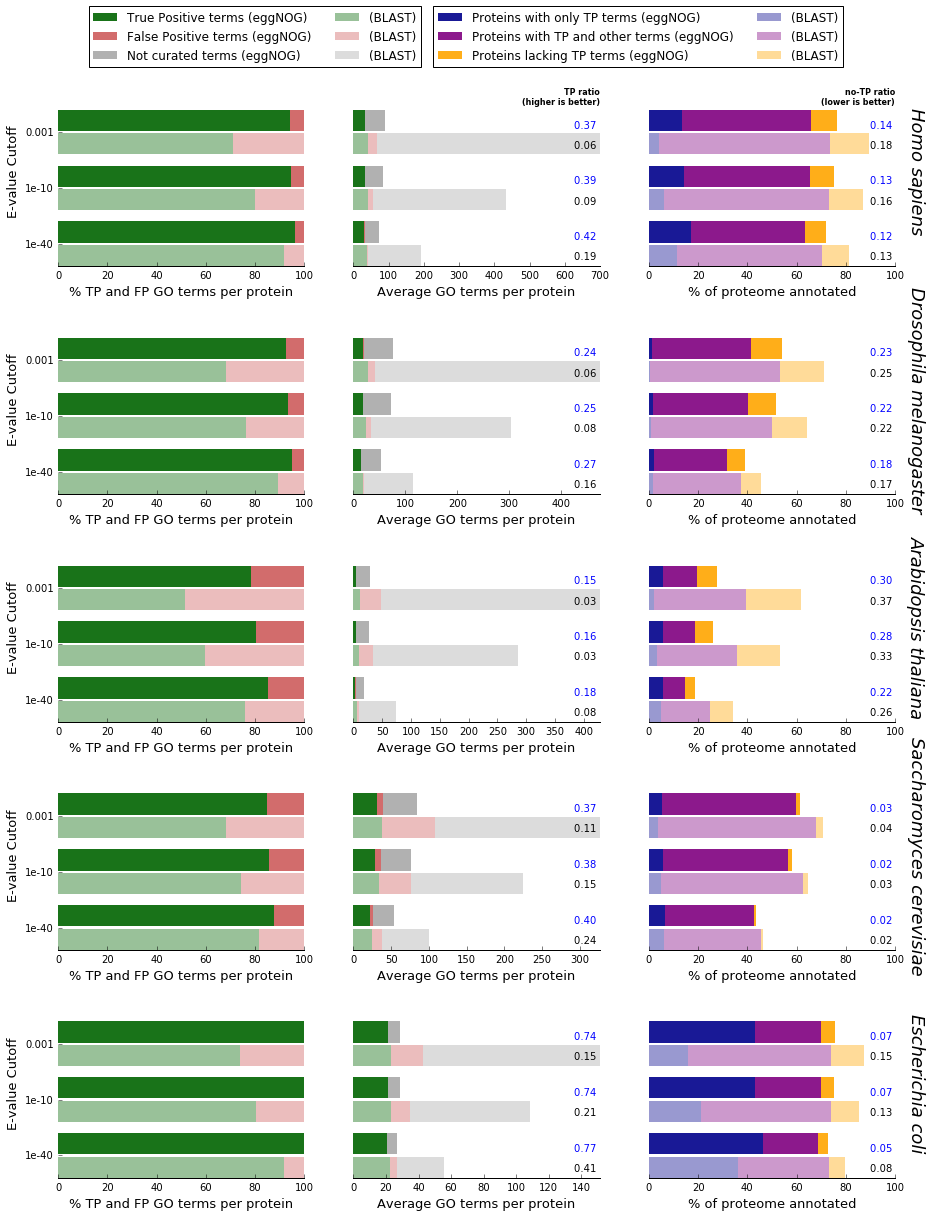

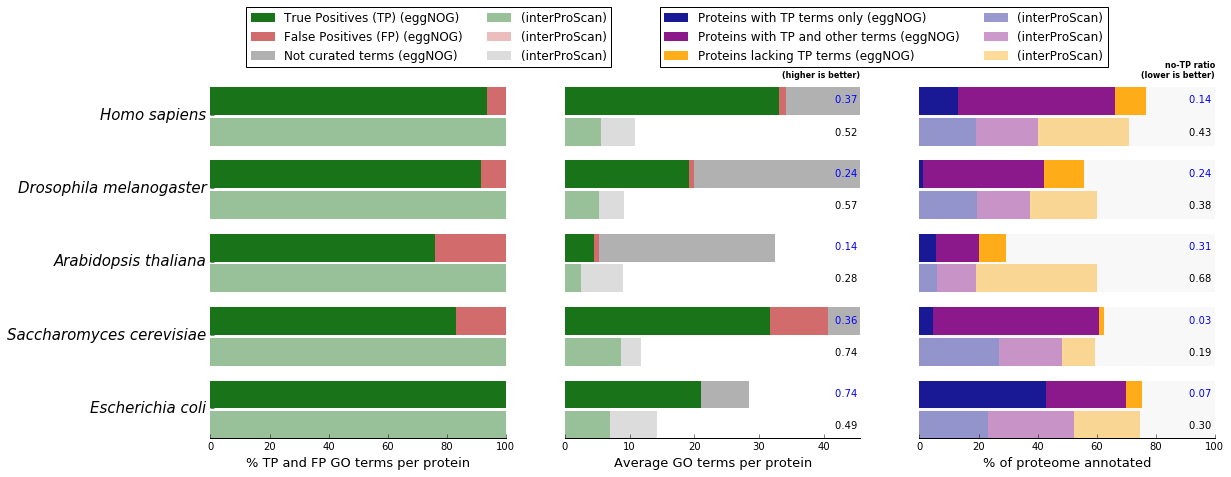

In [856]:
tag = 'excluded_self.all.NOG'
plot_blast_benchmark(bench[tag], TARGET_TAXA, EVALUE_CUTOFFS, "E-value Cutoff", tag)
plot_interpro_benchmark(bench[tag], TARGET_TAXA, tag)

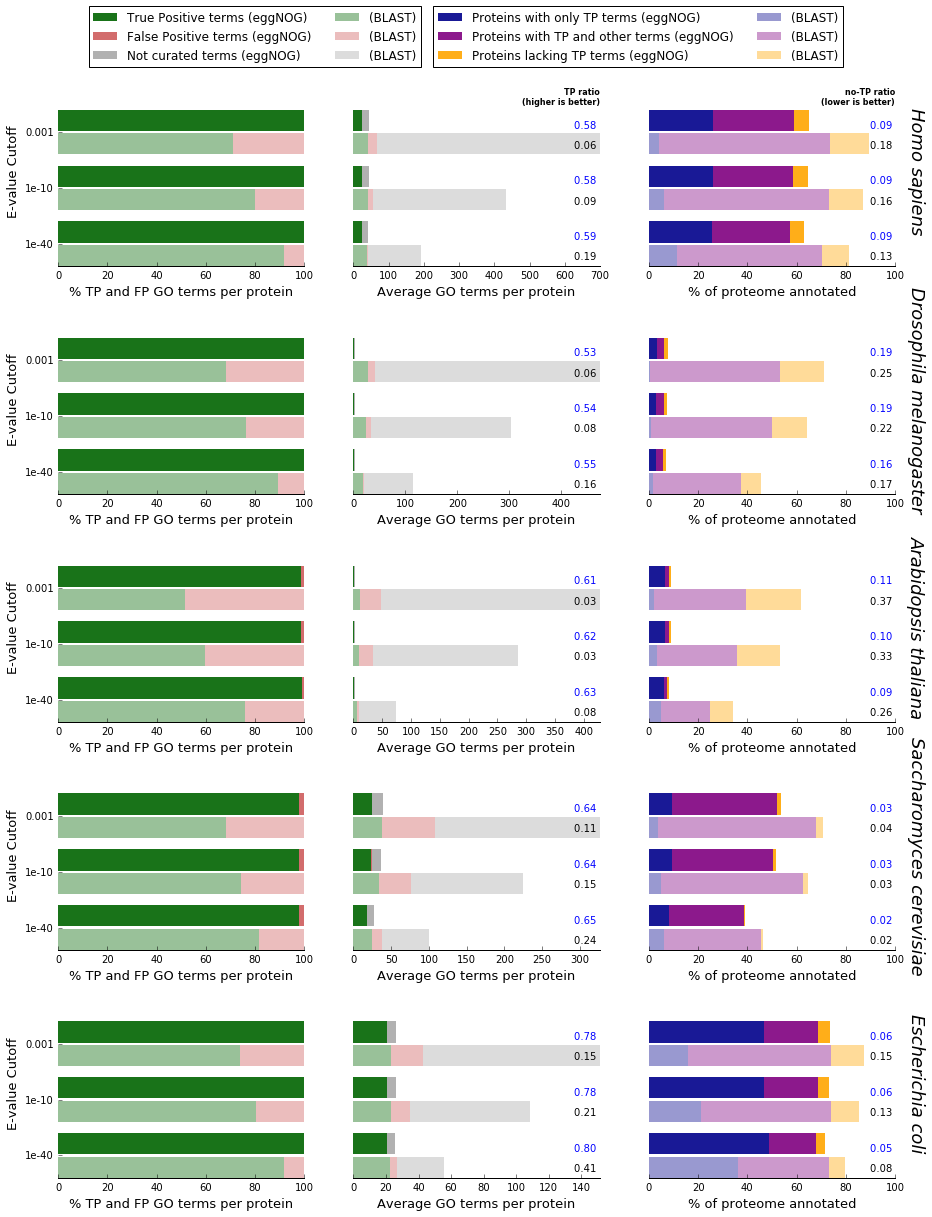

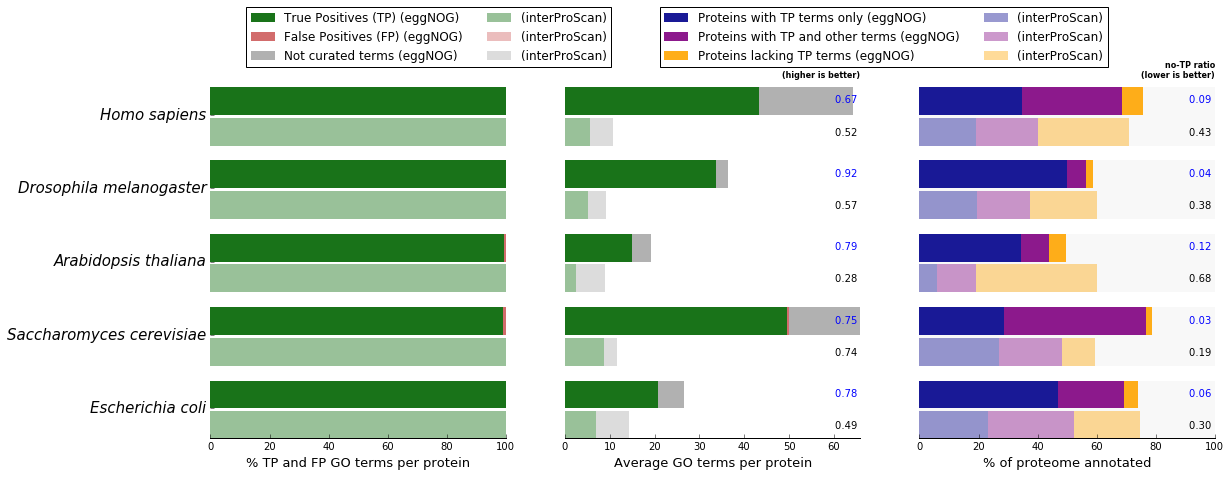

In [875]:
tag = 'all.auto'
plot_blast_benchmark(bench[tag], TARGET_TAXA, EVALUE_CUTOFFS, "E-value Cutoff", tag)
plot_interpro_benchmark(bench[tag], TARGET_TAXA, tag)

In [874]:
print_summary_table(bench['all.auto'])


eggNOG vs BLAST (% diff)
TP/FP_per_protein_ratio_diff    13.278431
TP_ratio_per_protein_diff       43.004491
total_terms_per_prot_diff      -19.970080
proteome_coverage_diff         -19.631973
notp_proteins_diff              -5.257530
tponly_proteins_diff            31.277008
Name: AVERAGE, dtype: float64

eggNOG vs interpro (% diff)
TP/FP_per_protein_ratio_diff    -0.303781
TP_ratio_per_protein_diff       26.246581
total_terms_per_prot_diff       32.097171
proteome_coverage_diff           2.230564
notp_proteins_diff             -32.735323
tponly_proteins_diff            30.817001
Name: AVERAGE, dtype: float64
------------------------------------------------------------

eggNOG vs BLAST (% diff)
                                AVERAGE     MEDIAN        STD    sapiens  \
TP/FP_per_protein_ratio_diff  13.278431  10.569370   5.686972   8.267714   
TP_ratio_per_protein_diff     43.004491  39.469060   6.263451  39.395052   
total_terms_per_prot_diff    -19.970080 -21.985969  16.537629 -46.

In [855]:
print_summary_table(bench['excluded_self.all.NOG'])


eggNOG vs BLAST (% diff)
TP/FP_per_protein_ratio_diff     6.846289
TP_ratio_per_protein_diff       19.060301
total_terms_per_prot_diff      -42.513517
proteome_coverage_diff          -8.231882
notp_proteins_diff              -1.762238
tponly_proteins_diff             9.388069
Name: AVERAGE, dtype: float64

eggNOG vs interpro (% diff)
TP/FP_per_protein_ratio_diff   -11.082567
TP_ratio_per_protein_diff      -15.333038
total_terms_per_prot_diff       22.872367
proteome_coverage_diff          -5.119285
notp_proteins_diff             -23.788905
tponly_proteins_diff            -8.801171
Name: AVERAGE, dtype: float64
------------------------------------------------------------

eggNOG vs BLAST (% diff)
                                AVERAGE     MEDIAN        STD    sapiens  \
TP/FP_per_protein_ratio_diff   6.846289   6.351251   1.685071   8.266110   
TP_ratio_per_protein_diff     19.060301  15.802522   9.564646  35.912983   
total_terms_per_prot_diff    -42.513517 -46.935001  10.418137 -48.

##  BLAST vs EGGNOG (sequence identity cutoffs)

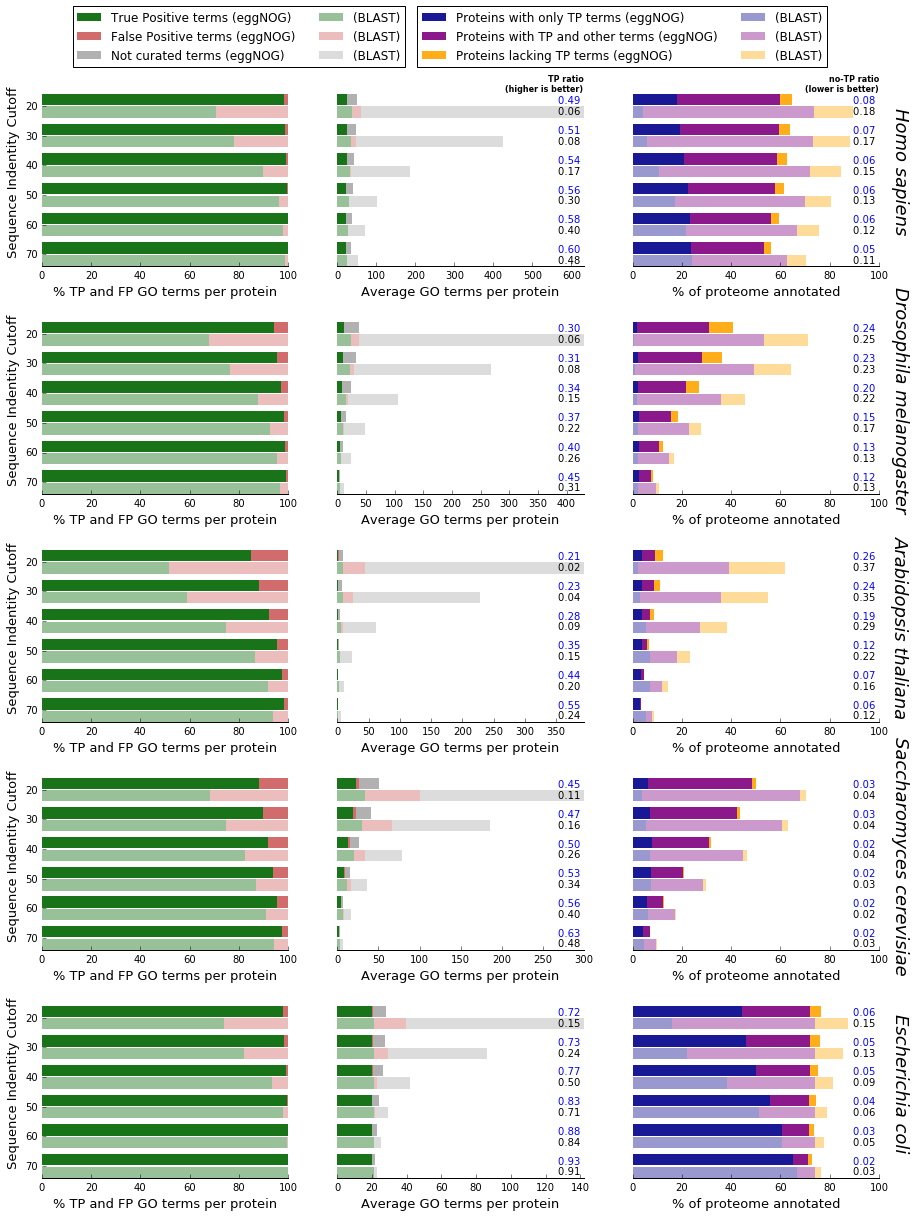

In [555]:
plot_blast_benchmark(bench['emapper_hmm'], TARGET_TAXA, IDENT_CUTOFFS, "Sequence Indentity Cutoff", RESULTS_DIR)